METHOD 1

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

# 1. Load the data
df = pd.read_csv('Data/colon-dataset-processed.csv')

# 2. Split the data
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Feature selection using RFE
correlations = X_train.corrwith(y_train.apply(lambda x: 1 if x == 'diagnosed' else 0))  # assuming 'diagnosed' and 'healthy' are the two classes
top_features = correlations.abs().nlargest(5).index  # taking top 5 features with highest absolute correlation
X_train_selected = X_train_scaled[:, X.columns.get_indexer(top_features)]
X_test_selected = X_test_scaled[:, X.columns.get_indexer(top_features)]

# 5. Hyperparameter optimization using GridSearchCV
params = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(KNeighborsClassifier(), params, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

# Fetch the best estimator
best_knn = grid_search.best_estimator_

# Test the model on the test set
accuracy = best_knn.score(X_test_selected, y_test)
print(f"Optimized Test Accuracy: {accuracy*100:.2f}%")


Optimized Test Accuracy: 78.26%


METHOD 2

In [2]:
# Block 1: Import necessary libraries and modules

import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split


In [3]:
# Block 2: Define the KNN class

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [np.sqrt(np.sum((x - x_train)**2)) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Return the most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]


In [4]:
# Block 3: Load the dataset

df = pd.read_csv('Data/colon-dataset-processed.csv')


In [5]:
# Block 4: Split the data into training and test sets

from sklearn.calibration import LabelEncoder
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Block 5: Find the best k value and train the model

best_k = 1
best_accuracy = 0

for k in range(1, 21):
    knn = KNN(k=k)
    knn.fit(X_train.values, y_train.values)
    predictions = knn.predict(X_test.values)
    accuracy = np.mean(predictions == y_test.values)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"Best k: {best_k}")
print(f"Accuracy with best k: {best_accuracy*100:.2f}%")


Best k: 3
Accuracy with best k: 86.96%


VISUALIZE THE CONFUSION MATRIX

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.90      0.82      0.86        11

    accuracy                           0.87        23
   macro avg       0.87      0.87      0.87        23
weighted avg       0.87      0.87      0.87        23



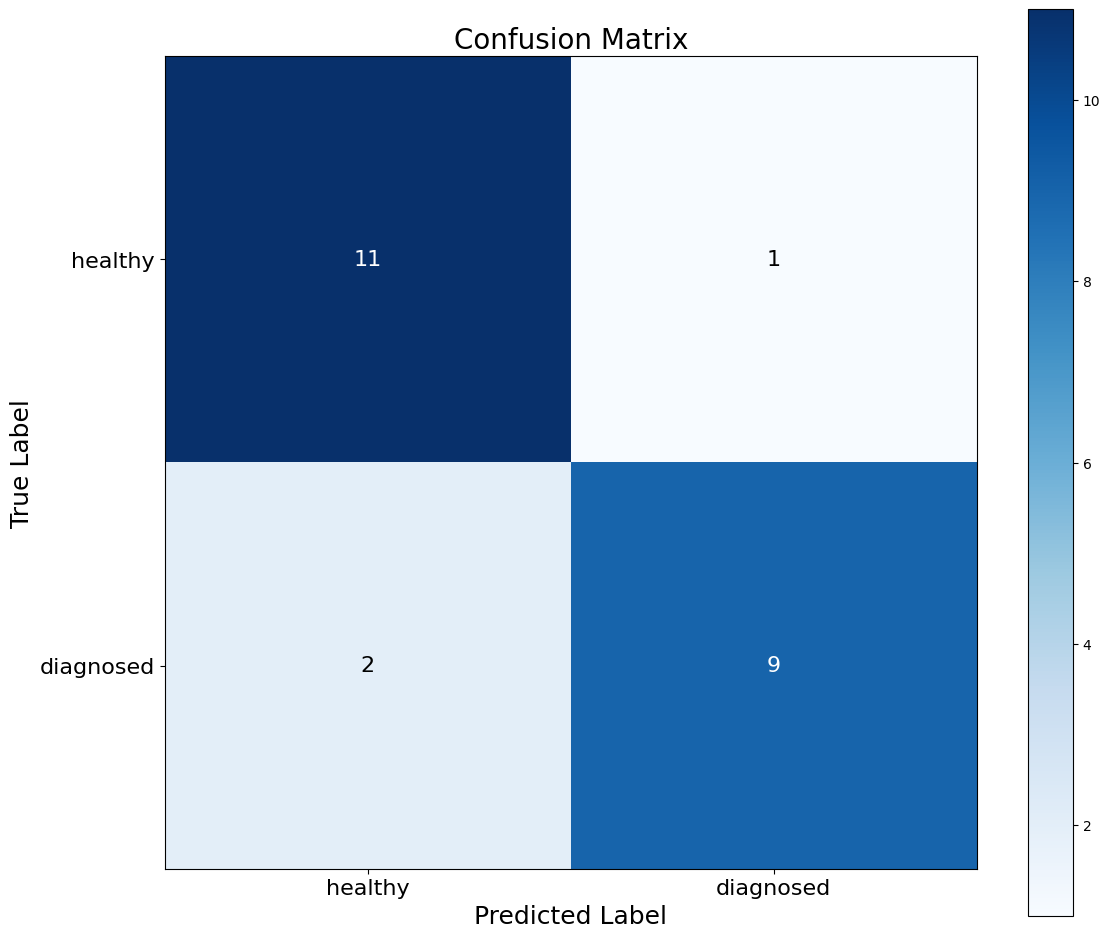

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

knn_best = KNN(k=best_k)
knn_best.fit(X_train.values, y_train.values)
y_pred = knn_best.predict(X_test.values)

#classifiction report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Enhanced confusion matrix plotting
fig, ax = plt.subplots(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)

# Display the heatmap
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set the x and y ticks, labels, and title with increased font size
ax.set(xticks=np.arange(cm.shape[1]), 
       yticks=np.arange(cm.shape[0]),
       xticklabels=['healthy', 'diagnosed'], 
       yticklabels=['healthy', 'diagnosed'],
       title="Confusion Matrix",
       xlabel="Predicted Label",
       ylabel="True Label")
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

# Loop over data dimensions and create text annotations with increased font size
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", 
                color="white" if cm[i, j] > cm.max() / 2. else "black", fontsize=16)

plt.tight_layout()
plt.show()


In [8]:
import pickle
with open('Models/KNN_model.pkl', 'wb') as f:
    pickle.dump(knn_best, f)